In [1]:
import torch
import math
import os
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
#@title Set up the SDE
import functools

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_dir = './results/ScoreNet'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  # t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE. a hyper-parameter

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [3]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # x is a vector of time steps. The dim of the results is (len(x), embed_dim).
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)

In [4]:
class ScoreNet(nn.Module):
    def __init__(self, marginal_prob_std, embed_dim, dim, drop_p=0.3, device='cpu'):
        super().__init__()
        self.device = device
        self.marginal_prob_std = marginal_prob_std
        self.act = lambda x: x * torch.sigmoid(x)
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim), nn.Linear(embed_dim, embed_dim))
        self.embedding_layer = Dense(embed_dim, 256)
        self.linear_model1 = nn.Sequential(
            nn.Linear(dim, 256),
            nn.Dropout(drop_p),
            nn.GELU(),
        )
        # Condition sigmas
        # self.embedding_layer = nn.Embedding(embed_dim, 256)

        self.linear_model2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.Dropout(drop_p),
            nn.GELU(),

            nn.Linear(512, 512),
            nn.Dropout(drop_p),
            nn.GELU(),

            nn.Linear(512, dim),
        )

        self.to(device = self.device)

    def forward(self, x, t):
        embed = self.act(self.embed(t))
        output = self.linear_model1(x)
        output = self.linear_model2(output + self.embedding_layer(embed))
        return output
        
    def loss(self, x, eps=1e-5):
        """The loss function for training score-based generative models.

        Args:
            model: A PyTorch model instance that represents a 
            time-dependent score-based model.
            x: A mini-batch of training data.    
            marginal_prob_std: A function that gives the standard deviation of 
            the perturbation kernel.
            eps: A tolerance value for numerical stability.
        """
        random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
        z = torch.randn_like(x)
        std = self.marginal_prob_std(random_t)
        perturbed_x = x + z * std[:, None]
        score = self.forward(perturbed_x, random_t)
        loss = torch.mean(torch.sum((score * std[:, None] + z)**2))
        return loss

In [5]:
# x = data
# eps = 0.01
# random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
# z = torch.randn_like(x)
# std = model.marginal_prob_std(random_t)
# perturbed_x = x + z * std[:, None]
# score = model.forward(perturbed_x, random_t)

In [6]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  500  #@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cpu', 
                           eps=1e-3,
                           only_final=True):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  sampling_list = []
  t = torch.ones(batch_size, device=device)
  # set t=1 to approximate the marginal distribution, init_x
  init_x = torch.randn(batch_size, 2, device=device) \
    * marginal_prob_std(t)[:, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in time_steps:      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)  
      if not only_final:
        sampling_list.append(x)   
  # Do not include any noise in the last sampling step.
  return mean_x if only_final else torch.stack(sampling_list)


sampler = Euler_Maruyama_sampler

In [18]:
@torch.no_grad()
def forward_process(x,
                    marginal_prob_std,
                    batch_size=64,
                    num_steps=10,
                    device='cpu',
                    eps=1e-3,
                    only_final=True):
    sampling_list = []
    time_steps = torch.linspace(eps, 1., num_steps, device=device)
    if only_final:
        return x + marginal_prob_std(time_steps[-1]) * torch.randn_like(x)
    else:
        for time_step in time_steps:
            sampling_list.append(x + marginal_prob_std(time_step) * torch.randn_like(x))
        return torch.stack(sampling_list)

In [8]:
eps = 1e-6
n_steps = 10
annealed_step = 100
total_iteration = 5000
scatter_range = [-10, 10]

In [9]:
model = ScoreNet(marginal_prob_std=marginal_prob_std_fn, embed_dim=20, dim=2, drop_p=0.3, device=device)
optim = torch.optim.Adam(model.parameters(), lr = 0.005)

In [10]:
from utils import *

dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.5
batch_size = 200
dataloader = torch.utils.data.DataLoader(Cluster2DataSet(dist1, dist2, probability=probability, total_len=batch_size * total_iteration), batch_size = batch_size, drop_last = True)
dataiterator = iter(dataloader)

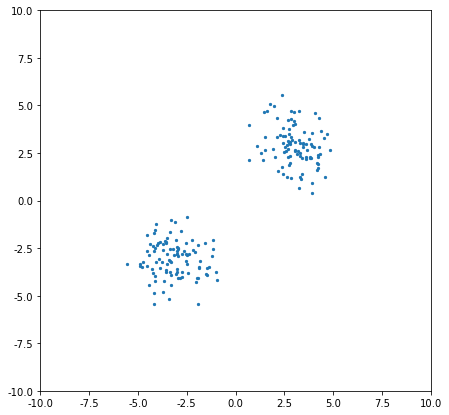

In [11]:
scatter(next(iter(dataloader)), True)

In [12]:
for i in range(total_iteration):
    try:
        data = dataiterator.next()
    except:
        dataiterator = iter(dataloader)
        data = dataiterator.next()
    data = data.to(device = device)

    loss_sn = model.loss(data)
    optim.zero_grad()
    loss_sn.backward()
    optim.step()

    if (i+1) % 100 == 0:
        print("Iteration[{}/{}], Diffuse loss: {:.4f}"
                .format(i+1, total_iteration, loss_sn.item()))

        with torch.no_grad():
            samples = sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size, device=device)
            scatter(samples, only_final=True, scatter_range = scatter_range)
            plt.savefig(os.path.join(sample_dir, 'diffused-{}.png'.format(i+1)))
            plt.close('all')

Iteration[100/5000], Diffuse loss: 290.8895


/home/wangxu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration[200/5000], Diffuse loss: 270.6795
Iteration[300/5000], Diffuse loss: 268.5541
Iteration[400/5000], Diffuse loss: 242.0709
Iteration[500/5000], Diffuse loss: 240.0800
Iteration[600/5000], Diffuse loss: 202.8777
Iteration[700/5000], Diffuse loss: 226.1068
Iteration[800/5000], Diffuse loss: 168.5800
Iteration[900/5000], Diffuse loss: 239.6852
Iteration[1000/5000], Diffuse loss: 196.0682
Iteration[1100/5000], Diffuse loss: 179.9573
Iteration[1200/5000], Diffuse loss: 239.6970
Iteration[1300/5000], Diffuse loss: 228.1127
Iteration[1400/5000], Diffuse loss: 205.5866
Iteration[1500/5000], Diffuse loss: 204.6379
Iteration[1600/5000], Diffuse loss: 210.0364
Iteration[1700/5000], Diffuse loss: 221.2236
Iteration[1800/5000], Diffuse loss: 201.8888
Iteration[1900/5000], Diffuse loss: 216.5344
Iteration[2000/5000], Diffuse loss: 209.6646
Iteration[2100/5000], Diffuse loss: 219.1875
Iteration[2200/5000], Diffuse loss: 206.9235
Iteration[2300/5000], Diffuse loss: 202.5968
Iteration[2400/500

/home/wangxu/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


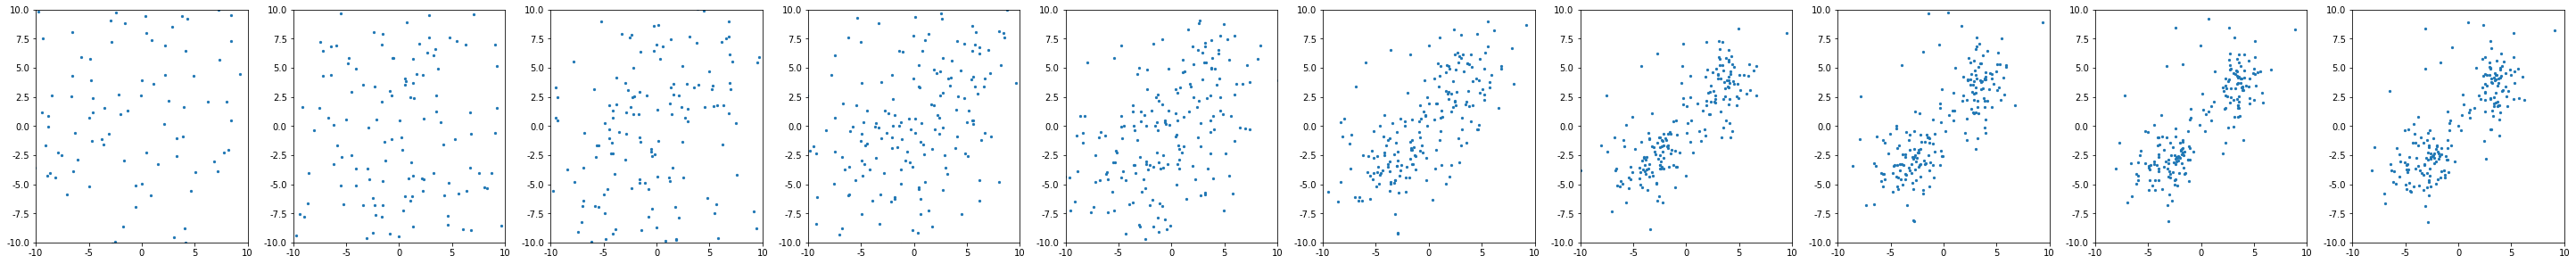

In [13]:
# Reverse process
samples = sampler(model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size, num_steps=10, device=device, only_final=False)
scatter(samples, only_final=False)

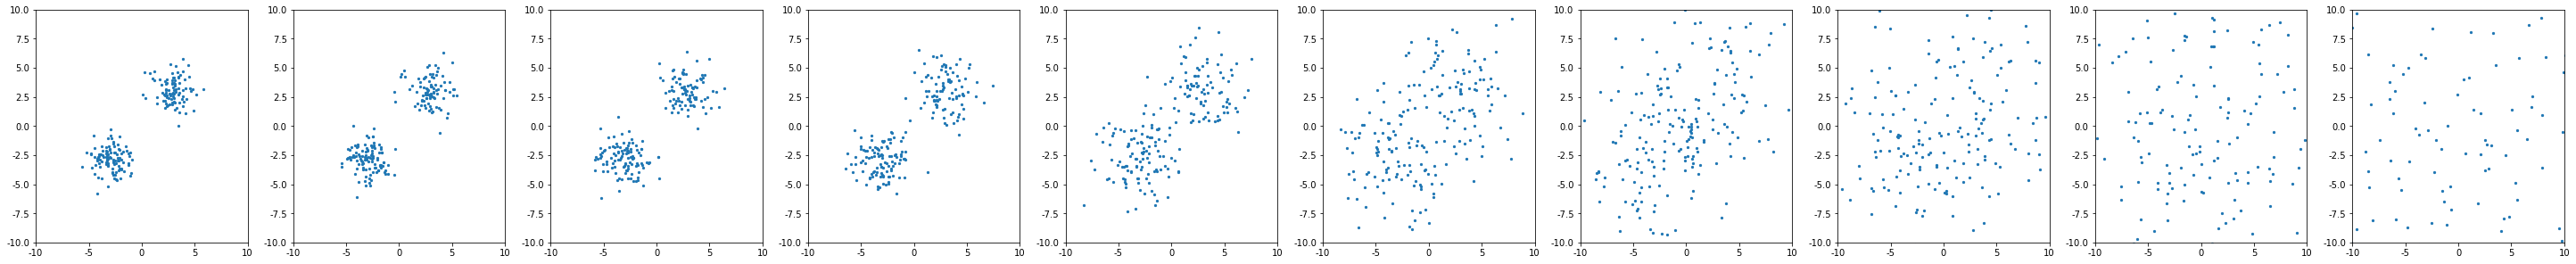

In [19]:
# Forward process
samples = forward_process(data, marginal_prob_std_fn, batch_size, num_steps=10, device=device, only_final=False)
scatter(samples, only_final=False)